In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from functools import partial

from dso.distributions import Gaussian
from dso.kernels import (
    GaussianKernel,
    SteinKernel,
)
from dso.discrepancies import KernelSteinDiscrepancy

ModuleNotFoundError: No module named 'dso'

In [2]:
np.random.seed(0)
plt.rc("legend", fontsize=7)

In [3]:
q_sigmas = np.arange(0.1, 2, 0.001)
ksd_vals = []
Y = np.random.multivariate_normal(mean=np.array([0]), cov=np.array([[0.5]]), size=1000)
rbf_kernel = GaussianKernel(sigma=0.1)


def compute_ksd_for_sigma(sigma, Y, rbf_kernel):
    gaussian = Gaussian(mu=np.zeros((1, 1)), covariance=np.array([[sigma]]))
    stein_kernel = SteinKernel(kernel=rbf_kernel, distribution=gaussian)
    ksd = KernelSteinDiscrepancy(stein_kernel=stein_kernel)
    return ksd.compute(Y)

In [4]:
with ProcessPoolExecutor(max_workers=10) as executor:
    ksd_vals = list(
        tqdm(
            executor.map(
                partial(compute_ksd_for_sigma, Y=Y, rbf_kernel=rbf_kernel), q_sigmas
            ),
            total=len(q_sigmas),
        )
    )

100%|██████████| 1900/1900 [21:52<00:00,  1.45it/s]


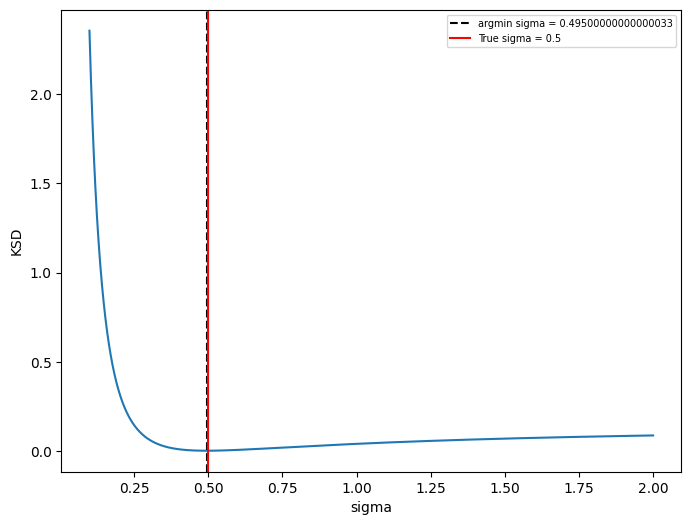

In [13]:
# sigma that minimizes KSD
min_sigma = q_sigmas[np.argmin(ksd_vals)]

plt.figure(figsize=(8, 6))
plt.plot(q_sigmas, ksd_vals, linestyle="-")
plt.xlabel("sigma")
plt.ylabel("KSD")

plt.axvline(
    x=min_sigma, color="black", linestyle="--", label=f"argmin sigma = {min_sigma}"
)
plt.axvline(x=0.5, color="red", linestyle="-", label="True sigma = 0.5")
plt.legend()
plt.show()